## Seleção de Features

Neste tópico abordaremos a seleção de features, utilizando o método Boruta, teste de Chi2 e Correlação point-biserial para tal.

Chi2*: Método utilizado para seleção de features categóricas ordinais e nominais. É um método que avalia a indepedência das features em relação ao target.

Boruta: Método muito robusto e baseado em modelo, que leva em consideração a interação entre a features, algo nao levado em conta pelo Chi2 ou outros métodos univariados de seleção. 

Para mais informações sobre o Boruta: https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

## Depêndencias

In [1]:
#Importando bibliotecas
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cloudpickle
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.api.types import is_numeric_dtype
from src.selecao_de_features import boruta_selector,chi_squared,plot_correlação
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

## Dados e Constantes

In [2]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'diabetes_data.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'test_inter.csv'
DATA_INTER_TRAIN_NAME = 'train_inter.csv'
DATA_INTER_TRAIN_FT_SELECTION = 'train_inter_ft_selection.csv'
META_DATA_PATH = os.path.join(DATA_RAW_PATH,'dicionario_tipos.pkl')
TARGET = 'target'

In [3]:
#Dados do dicionário
with open(META_DATA_PATH,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)
df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME), dtype=dicionario_tipo)

In [4]:
df_train.head()

,idade,genero,polyuria,polydipsia,perda_de_peso_repentina,fraqueza,polyphagia,candidiase_genital,desfoque_visual,coceira,irritabilidade,cicatrizacao_retardada,paresia_parcial,rigidez_muscular,alopecia,obesidade,target
0,67,male,no,no,no,no,yes,no,yes,no,no,no,no,yes,no,no,negative
1,55,female,yes,yes,yes,no,yes,no,no,yes,no,yes,yes,no,no,no,positive
2,60,male,no,no,no,yes,no,no,no,no,no,no,yes,yes,no,no,negative
3,48,female,yes,yes,no,yes,no,no,yes,yes,no,yes,yes,no,no,no,positive
4,31,female,yes,yes,yes,yes,yes,no,no,yes,yes,no,yes,yes,no,no,positive


## Iniciando análises para seleção

In [5]:
#Utilizando apenas as variaveis numericas.
todas_as_variaveis = set(df_train.columns.tolist())
variaveis_categoricas = set(df_train.select_dtypes(include=['object']).columns.tolist())
variaveis_numericas = todas_as_variaveis - variaveis_categoricas
variaveis_categoricas = list(variaveis_categoricas)

## Abordagem (Correlação+Chi2+Boruta)

## Correlação

In [46]:
df_train_copy = df_train.copy()

A Correlação não descartou nenhuma variável. 

In [47]:
#Plot da distribuição da variável target.
df_train['target'] = df_train['target'].map({'positive': 1, 'negative': 0})
df_train['genero'] = df_train['genero'].map({'female':0, 'male': 1})

In [48]:
list_yes_no = ['polyuria', 'polydipsia', 'perda_de_peso_repentina', 'fraqueza', 'polyphagia', 'candidiase_genital', 'desfoque_visual', 'coceira', 'irritabilidade', 'cicatrizacao_retardada', 'paresia_parcial', 'rigidez_muscular', 'alopecia', 'obesidade']
for lista in list_yes_no:
    df_train[lista] = df_train[lista].map({"no":0, "yes":1}.get)

/home/graziellymo/Documents/pessoal/Estudo DS/case-sbf-diabetes/src/selecao_de_features.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  corrmat = df.astype('int').loc[:,lista_de_variaveis].corr(method='pearson')


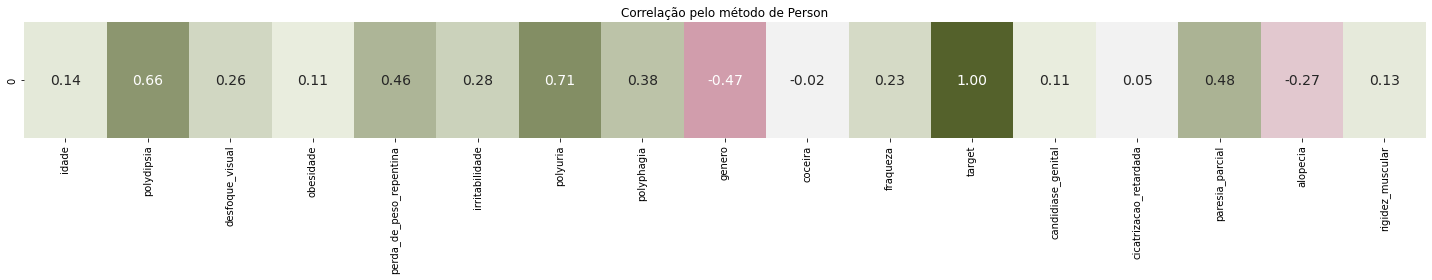

In [49]:
plot_correlação(todas_as_variaveis,df_train)

In [50]:
corr_matrix = df_train.loc[:,todas_as_variaveis].corr()

/tmp/ipykernel_307527/2748440595.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  corr_matrix = df_train.loc[:,todas_as_variaveis].corr()


In [51]:
#Filtros para Correlação em relação ao target.
lista_correlacao = corr_matrix['target'].sort_values(axis=0,ascending=False).iloc[1:]
lista_correlacao = abs(lista_correlacao)

In [52]:
#Lista de Variáveis númericas descartadas com base na correlação.
lista_descart_corr = lista_correlacao[lista_correlacao < 0.01].index.tolist()

In [53]:
lista_descart_corr

[]

## Chi2

In [6]:
chi2_df, logs = chi_squared(df_train, y ='target', cols = variaveis_categoricas)

In [7]:
chi2_df

,column,p-value,chi2_value
0,paresia_parcial,4.934038e-22,93.115079
1,genero,1.366399e-21,91.099301
2,polyuria,2.743055e-47,208.623267
3,candidiase_genital,3.097391e-02,4.654408
4,cicatrizacao_retardada,4.130320e-01,0.670056
5,desfoque_visual,2.937352e-07,26.290466
6,target,NaN,NaN
7,polyphagia,2.445415e-14,58.136541
8,irritabilidade,1.394289e-08,32.195282
9,obesidade,2.908504e-02,4.762573


In [8]:
logs

['A coluna target não pode ser avaliada. ']

Com é o próprio target, não calculamos o chi2 para ele.
* Hipótese nula - H0: As variáveis são independente. 
- Segundo o teste de hipotése realizado, as variáveis cujo p-valor < 0.05 tem relação com o target.

In [9]:
#As variáveis que serão excluídas. 
lista_descart_chi2 = chi2_df[chi2_df['p-value']>=0.05]['column'].tolist()

In [10]:
lista_descart_chi2

['cicatrizacao_retardada', 'coceira']

As variáveis que foram descartas pelo teste de Chi-2 foram, `cicatrização_retardada` e `coceira`, logo mais elas serão descartadas para a modelagem. 

## Boruta

In [11]:
#Vamos filtrar as Features removidas no step anterior antes de passarmos para o Boruta
list_to_drop_boruta = boruta_selector(df_train.drop(lista_descart_chi2,axis=1), y='target')

In [12]:
#Lista de dropagem Geral (chi2 + boruta)
lista_drop_geral = set(lista_descart_chi2+list_to_drop_boruta)
lista_drop_geral

{'candidiase_genital',
 'cicatrizacao_retardada',
 'coceira',
 'desfoque_visual',
 'fraqueza',
 'obesidade',
 'rigidez_muscular'}

In [13]:
# dropando as colunas pela abordagem.
df_train_copy.drop(lista_drop_geral,axis=1).to_csv(os.path.join(DATA_INTER_PATH,DATA_INTER_TRAIN_FT_SELECTION), index=False)

A abordagem para seleção de features que utilizamos são (Chi2 e Boruta), que combinados trazem resultados bastante relevantes, descartando as variáveis que possuem menos relação com target e que consequentemente teriam um baixo poder preditivo. As features descartadas no boruta e Chi2   foram:`candidíase_genital`,`cicatrização_retardada`,`coceira`,`desfoque_visual`,`fraqueza`,`obesidade`, `regidez_muscular`. Todas essas features não serão consideradas para nosso modelo.